In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import shutil

drive_zip_path = "/content/drive/MyDrive/disaster_dataset.zip"
colab_zip_path = "/content/disaster_dataset.zip"

shutil.copy(drive_zip_path, colab_zip_path)
print("✔ Copied dataset to Colab storage.")

✔ Copied dataset to Colab storage.


In [4]:
import zipfile

extract_to = "/content/dataset"

with zipfile.ZipFile(colab_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("✔ Unzipped successfully!")


✔ Unzipped successfully!


In [5]:
import os

for root, dirs, files in os.walk("/content/dataset"):
    print(f"📁 Folder: {root}")
    print(f"📄 Files: {len(files)}")
    print("--------------------------")


📁 Folder: /content/dataset
📄 Files: 1
--------------------------
📁 Folder: /content/dataset/multimodal
📄 Files: 0
--------------------------
📁 Folder: /content/dataset/multimodal/damaged_infrastructure
📄 Files: 0
--------------------------
📁 Folder: /content/dataset/multimodal/damaged_infrastructure/images
📄 Files: 1418
--------------------------
📁 Folder: /content/dataset/multimodal/damaged_infrastructure/text
📄 Files: 1390
--------------------------
📁 Folder: /content/dataset/multimodal/non_damage
📄 Files: 0
--------------------------
📁 Folder: /content/dataset/multimodal/non_damage/images
📄 Files: 2972
--------------------------
📁 Folder: /content/dataset/multimodal/non_damage/text
📄 Files: 2957
--------------------------
📁 Folder: /content/dataset/multimodal/human_damage
📄 Files: 0
--------------------------
📁 Folder: /content/dataset/multimodal/human_damage/images
📄 Files: 241
--------------------------
📁 Folder: /content/dataset/multimodal/human_damage/text
📄 Files: 240
---------

In [6]:
!pip install -q -U transformers accelerate scikit-learn scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 68.6 MB/s eta 0:00:00


In [7]:
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, precision_score, recall_score,
    f1_score, roc_curve, roc_auc_score, auc
)

import torch
from torch.utils.data import Dataset

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)

import matplotlib.pyplot as plt
from scipy.special import softmax

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [8]:
base_dir = "/content/dataset/multimodal"


label2id = {
    "non_damage": 0,
    "damaged_infrastructure": 1,
    "damaged_nature": 2,
    "fires": 3,
    "flood": 4,
    "human_damage": 5
}
id2label = {v: k for k, v in label2id.items()}

texts = []
labels = []

for label_name, label_id in label2id.items():
    text_dir = os.path.join(base_dir, label_name, "text")
    print("Reading:", text_dir)
    for fname in os.listdir(text_dir):
        fpath = os.path.join(text_dir, fname)
        if not os.path.isfile(fpath):
            continue
        # accept any extension
        try:
            with open(fpath, "r", encoding="utf-8", errors="ignore") as f:
                content = f.read().strip()
        except Exception as e:
            print("Error reading", fpath, e)
            continue

        if len(content) == 0:
            continue

        texts.append(content)
        labels.append(label_id)

df = pd.DataFrame({"text": texts, "label": labels})
print("Total samples:", len(df))
print(df["label"].value_counts().sort_index())
print("Label mapping:", id2label)


Reading: /content/dataset/multimodal/non_damage/text
Reading: /content/dataset/multimodal/damaged_infrastructure/text
Reading: /content/dataset/multimodal/damaged_nature/text
Reading: /content/dataset/multimodal/fires/text
Reading: /content/dataset/multimodal/flood/text
Reading: /content/dataset/multimodal/human_damage/text
Total samples: 5831
label
0    2957
1    1390
2     514
3     346
4     384
5     240
Name: count, dtype: int64
Label mapping: {0: 'non_damage', 1: 'damaged_infrastructure', 2: 'damaged_nature', 3: 'fires', 4: 'flood', 5: 'human_damage'}


In [9]:

train_df, temp_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df["label"]
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    random_state=42,
    stratify=temp_df["label"]
)

print("Train size:", len(train_df))
print("Val size:", len(val_df))
print("Test size:", len(test_df))

print("\nTrain label distribution:")
print(train_df["label"].value_counts().sort_index())
print("\nVal label distribution:")
print(val_df["label"].value_counts().sort_index())
print("\nTest label distribution:")
print(test_df["label"].value_counts().sort_index())


Train size: 4664
Val size: 583
Test size: 584

Train label distribution:
label
0    2365
1    1112
2     411
3     277
4     307
5     192
Name: count, dtype: int64

Val label distribution:
label
0    296
1    139
2     51
3     35
4     38
5     24
Name: count, dtype: int64

Test label distribution:
label
0    296
1    139
2     52
3     34
4     39
5     24
Name: count, dtype: int64


In [39]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from torch.utils.data import Dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

model_name = "microsoft/deberta-v3-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)


Using: cuda


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [40]:
max_length = 128

class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = list(texts)
        self.labels = list(labels)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(label, dtype=torch.long)
        }

train_dataset = TextDataset(train_df["text"], train_df["label"], tokenizer, max_length)
val_dataset   = TextDataset(val_df["text"], val_df["label"], tokenizer, max_length)
test_dataset  = TextDataset(test_df["text"], test_df["label"], tokenizer, max_length)


In [41]:
num_labels = len(label2id)

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)

model.to(device)


pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DebertaV2ForSequenceClassification(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): Dropout(p=0.1, inplace=False)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): Layer

In [42]:
from torch.utils.data import DataLoader
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup

batch_size = 16
num_epochs = 5

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

optimizer = AdamW(model.parameters(), lr=2e-5)

total_steps = len(train_loader) * num_epochs

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(total_steps * 0.1),
    num_training_steps=total_steps
)


In [43]:
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
from tqdm import tqdm

def train_one_epoch(model, dataloader, optimizer, scheduler, device):
    model.train()
    total_loss = 0

    for batch in tqdm(dataloader, desc="Training", leave=False):
        optimizer.zero_grad()

        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)

        loss = outputs.loss
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)


def eval_one_epoch(model, dataloader, device):
    model.eval()
    total_loss = 0
    preds_list, labels_list = [], []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating", leave=False):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)

            total_loss += outputs.loss.item()

            preds = torch.argmax(outputs.logits, dim=-1)
            preds_list.extend(preds.cpu().numpy())
            labels_list.extend(batch["labels"].cpu().numpy())

    return (
        total_loss / len(dataloader),
        accuracy_score(labels_list, preds_list),
        f1_score(labels_list, preds_list, average="macro"),
        f1_score(labels_list, preds_list, average="weighted"),
    )


In [44]:
history = {"train_loss": [], "val_loss": [], "val_acc": [], "val_macro_f1": []}
best_model_path = "deberta_best.pt"
best_val_f1 = 0

for epoch in range(1, num_epochs + 1):
    print(f"\n===== Epoch {epoch}/{num_epochs} =====")

    train_loss = train_one_epoch(model, train_loader, optimizer, scheduler, device)
    val_loss, val_acc, val_macro_f1, val_weighted_f1 = eval_one_epoch(model, val_loader, device)

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)
    history["val_macro_f1"].append(val_macro_f1)

    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss:   {val_loss:.4f}")
    print(f"Val Acc:    {val_acc:.4f}")
    print(f"Val Macro F1: {val_macro_f1:.4f}")

    if val_macro_f1 > best_val_f1:
        best_val_f1 = val_macro_f1
        torch.save(model.state_dict(), best_model_path)
        print("🔥 Best model saved!")



===== Epoch 1/5 =====


Train Loss: 1.0422
Val Loss:   0.5941
Val Acc:    0.7804
Val Macro F1: 0.5032
🔥 Best model saved!

===== Epoch 2/5 =====


Train Loss: 0.4056
Val Loss:   0.4720
Val Acc:    0.8628
Val Macro F1: 0.7783
🔥 Best model saved!

===== Epoch 3/5 =====


Train Loss: 0.2689
Val Loss:   0.4454
Val Acc:    0.8679
Val Macro F1: 0.7984
🔥 Best model saved!

===== Epoch 4/5 =====


Train Loss: 0.1977
Val Loss:   0.4795
Val Acc:    0.8799
Val Macro F1: 0.8115
🔥 Best model saved!

===== Epoch 5/5 =====


Train Loss: 0.1544
Val Loss:   0.4642
Val Acc:    0.8902
Val Macro F1: 0.8253
🔥 Best model saved!


In [46]:
model.load_state_dict(torch.load(best_model_path))
model.eval()

y_true, y_pred = [], []

with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        logits = model(**batch).logits
        preds = torch.argmax(logits, dim=-1)

        y_pred.extend(preds.cpu().numpy())
        y_true.extend(batch["labels"].cpu().numpy())

print("\n Test Accuracy:", accuracy_score(y_true, y_pred))
print(" Test Macro F1:", f1_score(y_true, y_pred, average='macro'))
print(" Test Weighted F1:", f1_score(y_true, y_pred, average='weighted'))



 Test Accuracy: 0.910958904109589
 Test Macro F1: 0.8578324569608885
 Test Weighted F1: 0.9112586566500214


In [47]:
from sklearn.metrics import classification_report, confusion_matrix

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=[id2label[i] for i in range(num_labels)]))

print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))



Classification Report:
                        precision    recall  f1-score   support

            non_damage       0.98      0.97      0.98       296
damaged_infrastructure       0.89      0.88      0.88       139
        damaged_nature       0.78      0.77      0.78        52
                 fires       0.78      0.94      0.85        34
                 flood       0.74      0.74      0.74        39
          human_damage       0.95      0.88      0.91        24

              accuracy                           0.91       584
             macro avg       0.86      0.86      0.86       584
          weighted avg       0.91      0.91      0.91       584


Confusion Matrix:
[[288   5   0   2   1   0]
 [  2 122   6   2   6   1]
 [  4   3  40   3   2   0]
 [  0   1   0  32   1   0]
 [  0   4   5   1  29   0]
 [  0   2   0   1   0  21]]


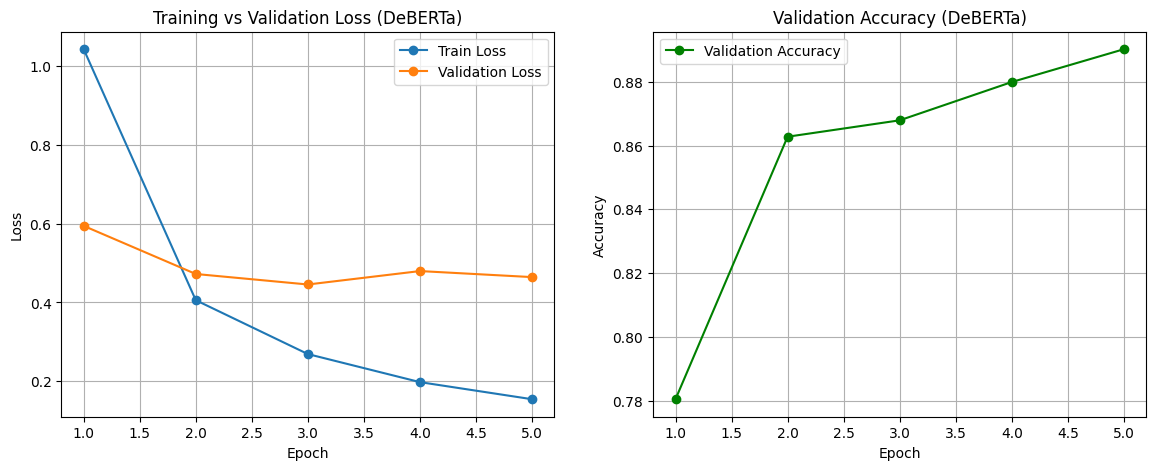

In [48]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(14,5))

# Loss
plt.subplot(1,2,1)
plt.plot(epochs, history['train_loss'], marker='o', label='Train Loss')
plt.plot(epochs, history['val_loss'], marker='o', label='Validation Loss')
plt.title("Training vs Validation Loss (DeBERTa)")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.grid(True); plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(epochs, history['val_acc'], marker='o', color='green', label='Validation Accuracy')
plt.title("Validation Accuracy (DeBERTa)")
plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.grid(True); plt.legend()

plt.show()
